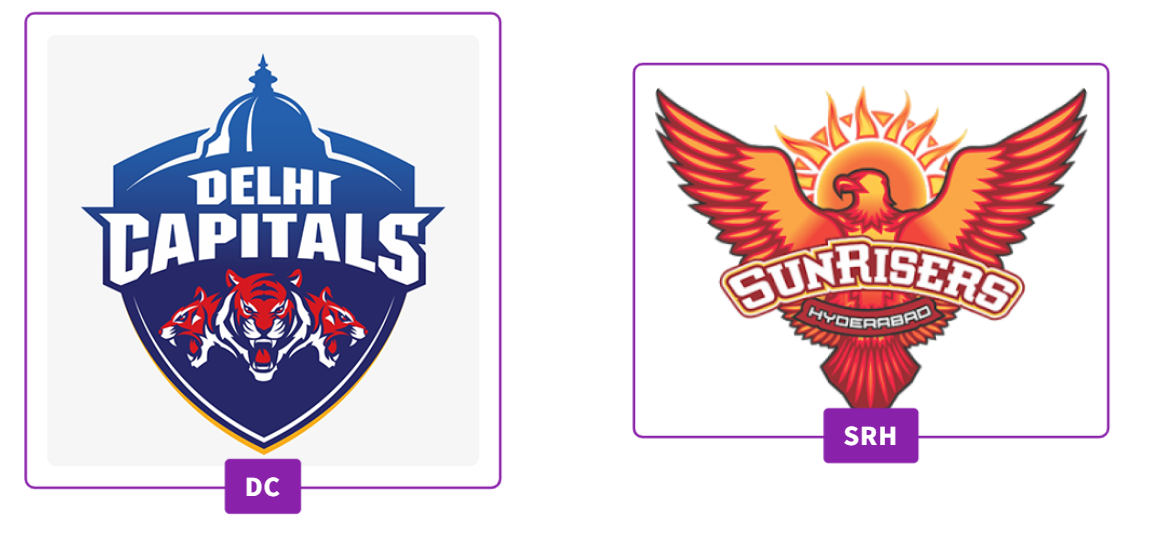

In [1]:
#!pip install bqplot
#!pip install ipywidgets
#!pip install ipympl
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter nbextension install --user --py widgetsnbextension
#!jupyter nbextension enable --user --py widgetsnbextension
#!pip install plotly
#!pip install cufflinks


import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
import bqplot
from bqplot import Pie
from collections import Counter
from bqplot import DateScale, LinearScale, Lines, Axis, Figure
from bqplot import Tooltip
import cufflinks as cf
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
pd.set_option('display.max_columns', 50)
%matplotlib widget


In [2]:
matches = pd.read_csv("matches.csv")
deliveries =  pd.read_csv("deliveries.csv")
IPL_data = pd.merge(deliveries, matches[['id','season', 'team1', 'team2', 'toss_winner', 'toss_decision','winner','result', 'dl_applied','win_by_runs','win_by_wickets', 'venue' ]], 
                    left_on='match_id', right_on='id')

In [78]:
SRH_batsmen = ['WP Saha','DA Warner','SP Goswami',  'MK Pandey', 'KS Williamson', 'JO Holder']# 'A Samad', 'P Garg']
# Samad and Garg no data available - score on an average 20 in 10-15 balls 
SRH_bowlers = ['Sandeep Sharma', 'Rashid Khan', 'S Nadeem',  'JO Holder', 'T Natarajan']

DC_batsmen  = ['P Shaw', 'S Dhawan', 'AM Rahane', 'SS Iyer', 'MP Stoinis', 'RR Pant', 'AR Patel']
DC_bowlers = ['K Rabada', 'AR Patel', 'R Ashwin', 'MP Stoinis', 'HV Patel']
# No data for Nortje, T Deshpande


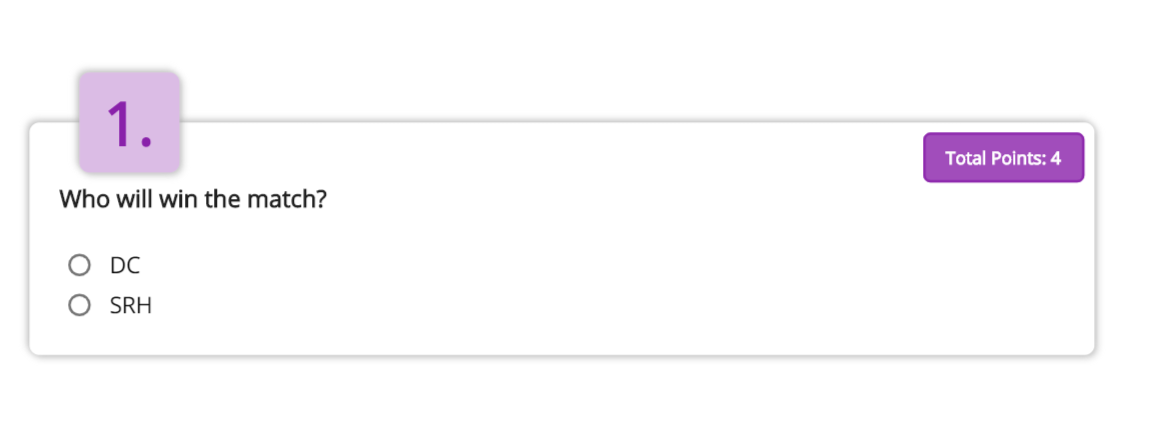

In [79]:
bowling_avg = deliveries[(deliveries.bowler.isin(DC_bowlers)) | (deliveries.bowler.isin(SRH_bowlers))]
bowling_avg.player_dismissed.fillna(0, inplace  = True)
bowling_avg['player_dismissed'].loc[bowling_avg['player_dismissed'] != 0] = 1

b_avg1 = bowling_avg.groupby(['bowler'])['player_dismissed'].sum().reset_index(name  = "wickets")
t_b =  bowling_avg.groupby(['bowler'])['batsman_runs'].count().reset_index(name  = "balls_bowled")
b_avg1["balls_bowled"] = t_b.balls_bowled
b_avg1["bowling_avg"] = b_avg1.wickets/b_avg1.balls_bowled


display_side_by_side([b_avg1[b_avg1.bowler.isin(SRH_bowlers)], b_avg1[b_avg1.bowler.isin(DC_bowlers)]], 
                     [" 1) bowling average of SRH bowlers", " 2) bowling average of DC bowlers"])


## Batting averages of all the batsmen

batsmen_runs_all =deliveries[(deliveries.batsman.isin(DC_batsmen)) | (deliveries.batsman.isin(SRH_batsmen))]
b1_all = batsmen_runs_all.groupby(['batsman'])['batsman_runs'].sum().reset_index(name = "total_runs")
b = [];b_avg = [];tm = [];runs  = []
for i in batsmen_runs_all.batsman.unique():
    x = batsmen_runs_all[batsmen_runs_all.batsman == i]
    x.player_dismissed.fillna(0, inplace = True)
    x['player_dismissed'].loc[x['player_dismissed'] != 0] = 1
    #print(x[['match_id','player_dismissed']])
    y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
    z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
    #print(y)
    b.append(i)
    b_avg.append(y.out_count.sum())
    runs.append(z.runs.sum())
    tm.append(y.shape[0])
    
bat_avg = pd.DataFrame(list(zip(b, b_avg, tm, runs)), 
               columns =['batsman','matches_out','total_matches', 'total_runs'])    

bat_avg["batting_average"] = bat_avg.total_runs/bat_avg.matches_out
#bat_avg[bat_avg.batsman.isin(SRH_batsmen)]
display_side_by_side([bat_avg[bat_avg.batsman.isin(SRH_batsmen)], bat_avg[bat_avg.batsman.isin(DC_batsmen)]], [" 1) batting average of SRH batsmen", " 2) batting average of DC batsmen"])

,bowler,wickets,balls_bowled,bowling_avg
2,JO Holder,8,228,0.035088
6,Rashid Khan,60,1106,0.054250
7,S Nadeem,47,1283,0.036633
8,Sandeep Sharma,90,1546,0.058215
9,T Natarajan,2,82,0.024390
,bowler,wickets,balls_bowled,bowling_avg
0,AR Patel,76,1745,0.043553
1,HV Patel,47,868,0.054147
3,K Rabada,36,434,0.082949
4,MP Stoinis,16,378,0.042328


,batsman,matches_out,total_matches,total_runs,batting_average
0,DA Warner,114,126,4741,41.587719
3,WP Saha,76,93,1780,23.421053
6,MK Pandey,96,119,2872,29.916667
9,KS Williamson,34,41,1319,38.794118
10,SP Goswami,18,19,301,16.722222
11,JO Holder,5,5,38,7.600000
,batsman,matches_out,total_matches,total_runs,batting_average
1,S Dhawan,137,158,4632,33.810219
2,AM Rahane,117,132,3850,32.905983
4,AR Patel,43,62,806,18.744186


## Performance indexes of batsmen
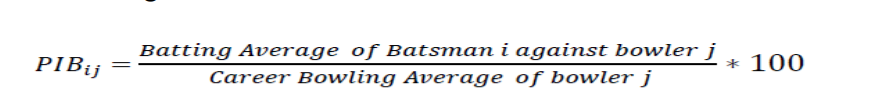

In [80]:
# Performance indexes of SRH batsmen against DC bowlers
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
def performance_indexes_batsmen(batsman_list, bowler_list):
    
    for i in batsman_list:
        pi1 = deliveries[(deliveries.batsman == i) & (deliveries.bowler.isin(bowler_list))]
        pi1.player_dismissed.fillna(0, inplace = True)
        pi1['player_dismissed'].loc[pi1['player_dismissed'] != 0] = 1
        for j in pi1.bowler.unique():
            x = pi1[pi1.bowler == j]
            batsman.append(i)
            bowler.append(j)
            y = x.groupby(['match_id'])['player_dismissed'].sum().reset_index(name = "out_count")
            z = x.groupby(['match_id'])['batsman_runs'].sum().reset_index(name = "runs")
            b_avg.append(y.out_count.sum())
            runs.append(z.runs.sum())
            tm.append(y.shape[0])
            
performance_indexes_batsmen(SRH_batsmen, DC_bowlers)
SRH_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
SRH_bat_avg["batting_average"] = SRH_bat_avg.total_runs/SRH_bat_avg.matches_out
SRH_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg = []
for i in SRH_bat_avg.bowler.values:
    bowl_avg.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
SRH_bat_avg["bowling_average_bowler"] = bowl_avg
SRH_bat_avg["PIBij"] = SRH_bat_avg.batting_average/SRH_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %

#############################################################################################################33
# DC batsmen's performance indexes
batsman = [];bowler =[]; b_avg= []; runs= []; tm = []
performance_indexes_batsmen(DC_batsmen, SRH_bowlers)

DC_bat_avg = pd.DataFrame(list(zip(batsman, bowler, b_avg, tm, runs)), 
               columns =['batsman','bowler', 'matches_out','total_matches', 'total_runs'])      
DC_bat_avg["batting_average"] = DC_bat_avg.total_runs/DC_bat_avg.matches_out
DC_bat_avg.replace([np.inf, -np.inf], np.nan, inplace=True)   

bowl_avg1 = []
for i in DC_bat_avg.bowler.values:
    bowl_avg1.append(b_avg1[b_avg1.bowler == i].bowling_avg.values[0])
    
DC_bat_avg["bowling_average_bowler"] = bowl_avg1
DC_bat_avg["PIBij"] = DC_bat_avg.batting_average/SRH_bat_avg.bowling_average_bowler # not multiplying with 100 as bowling average is not in %
display_side_by_side([SRH_bat_avg, DC_bat_avg], [" 1) Performance indexes of SRH batsmen against DC Bowlers", " 2) Performance indexes of DC batsmen against SRH Bowlers"])

,batsman,bowler,matches_out,total_matches,total_runs,batting_average,bowling_average_bowler,PIBij
0,WP Saha,HV Patel,1,1,8,8.000000,0.054147,147.744681
1,WP Saha,R Ashwin,0,4,10,nan,0.045756,nan
2,DA Warner,AR Patel,2,8,88,44.000000,0.043553,1010.263158
3,DA Warner,K Rabada,2,3,26,13.000000,0.082949,156.722222
4,DA Warner,R Ashwin,3,8,79,26.333333,0.045756,575.516908
5,DA Warner,HV Patel,0,5,63,nan,0.054147,nan
6,DA Warner,MP Stoinis,0,1,14,nan,0.042328,nan
7,MK Pandey,AR Patel,2,9,34,17.000000,0.043553,390.328947
8,MK Pandey,MP Stoinis,0,1,6,nan,0.042328,nan
9,MK Pandey,K Rabada,1,1,0,0.000000,0.082949,0.000000


## Performance indexes for both the teams bowlers
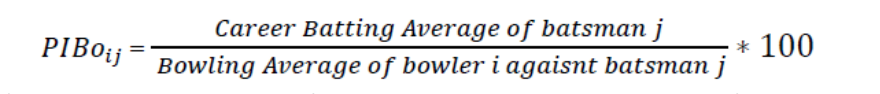

In [81]:
bowls = []; bats = []; wi = []; bb = []
def performance_index_bowlers(bowlers_list, batsmen_list):
    for i in bowlers_list:
        p = deliveries[(deliveries.bowler == i) & (deliveries.batsman.isin(batsmen_list))]
        p.player_dismissed.fillna(0, inplace  = True)
        p['player_dismissed'].loc[p['player_dismissed'] != 0] = 1
        for j in p.batsman.unique():
            bowls.append(i)
            bats.append(j)
            xy = p[p.batsman == j]
            #print(p[p.batsman == j])
            wi.append(xy.player_dismissed.sum())
            bb.append(xy.batsman_runs.count())
        
performance_index_bowlers(SRH_bowlers, DC_batsmen)
SRH_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in SRH_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
SRH_bowlers_p["bowling_average"] = SRH_bowlers_p.wickets/SRH_bowlers_p.balls_bowled
SRH_bowlers_p["batting_avg"] = bat_avg_p
SRH_bowlers_p["PIBoij"] = SRH_bowlers_p.batting_avg/SRH_bowlers_p.bowling_average
SRH_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)
###################################################################################################################
bowls = []; bats = []; wi = []; bb = []        
performance_index_bowlers(DC_bowlers, SRH_batsmen)

DC_bowlers_p = pd.DataFrame(list(zip(bowls, bats, wi, bb)), 
               columns =['bowler', 'batsman','wickets','balls_bowled'])  
bat_avg_p = []
for i in DC_bowlers_p.batsman.values:
    bat_avg_p.append(bat_avg[bat_avg.batsman == i].batting_average.values[0])
    
DC_bowlers_p["bowling_average"] = DC_bowlers_p.wickets/DC_bowlers_p.balls_bowled
DC_bowlers_p["batting_avg"] = bat_avg_p
DC_bowlers_p["PIBoij"] = DC_bowlers_p.batting_avg/DC_bowlers_p.bowling_average
DC_bowlers_p.replace([np.inf, -np.inf], np.nan, inplace=True)

display_side_by_side([SRH_bowlers_p, DC_bowlers_p], [" 1) Performance indexes of SRH bowlers against DC batsmen", " 2) Performance indexes of DC bowlers against SRH batsmen"])

,bowler,batsman,wickets,balls_bowled,bowling_average,batting_avg,PIBoij
0,Sandeep Sharma,AM Rahane,2,56,0.035714,32.905983,921.367521
1,Sandeep Sharma,S Dhawan,0,44,0.000000,33.810219,nan
2,Sandeep Sharma,SS Iyer,3,35,0.085714,30.070175,350.818713
3,Sandeep Sharma,RR Pant,1,13,0.076923,36.571429,475.428571
4,Sandeep Sharma,P Shaw,1,13,0.076923,25.666667,333.666667
5,Rashid Khan,AR Patel,1,10,0.100000,18.744186,187.441860
6,Rashid Khan,SS Iyer,1,51,0.019608,30.070175,1533.578947
7,Rashid Khan,RR Pant,2,37,0.054054,36.571429,676.571429
8,Rashid Khan,AM Rahane,0,32,0.000000,32.905983,nan
9,Rashid Khan,P Shaw,1,9,0.111111,25.666667,231.000000


### SRH will win today

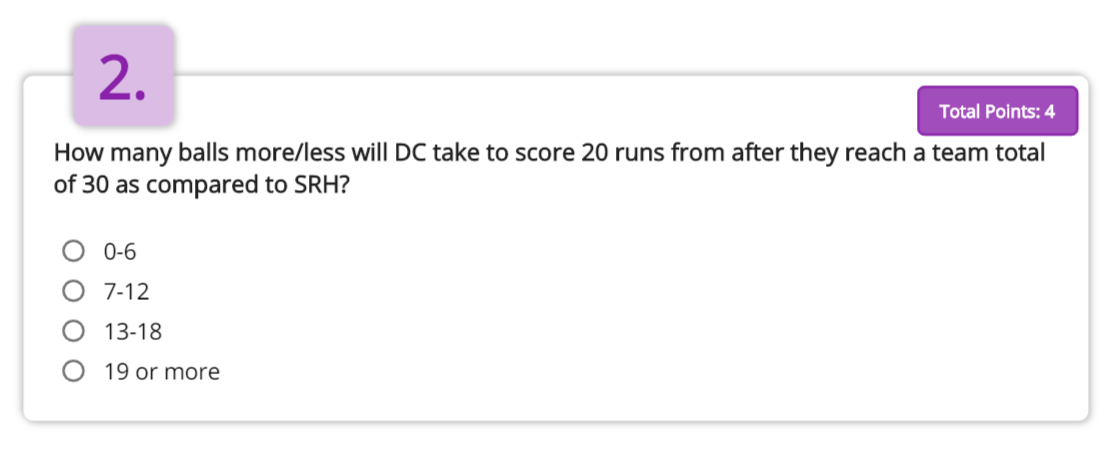

In [82]:
# Average scores by batsmen of SRH and DC
def average_scores(players_data):
    
    for i in players_data.batsman.unique():
        balls.append(players_data[players_data.batsman ==i].balls_faced.mean())
        r_scored.append(players_data[players_data.batsman ==i].runs_scored.mean())
        batsman_name.append(i)
    
    DC_SRH_runs_data =  pd.DataFrame(list(zip(batsman_name, balls, r_scored)), 
               columns =['batsman','balls_faced','runs_scored'])
    return DC_SRH_runs_data


batsmen_runs_all =deliveries[(deliveries.batsman.isin(DC_batsmen)) | (deliveries.batsman.isin(SRH_batsmen))]
DC_SRH_b = batsmen_runs_all.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
DC_SRH_runs = batsmen_runs_all.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
DC_SRH_runs["runs_scored"] = DC_SRH_b.runs_scored
r_scored=[];batsman_name=[];balls = []
DC_SRH_runs_data_ = average_scores(DC_SRH_runs)

display_side_by_side([DC_SRH_runs_data_[DC_SRH_runs_data_.batsman.isin(DC_batsmen)], 
                      DC_SRH_runs_data_[DC_SRH_runs_data_.batsman.isin(SRH_batsmen)]],
                     [" 1) Runs scored by DC batsmen", " 2) Runs scired by SRH batsmen"])

,batsman,balls_faced,runs_scored
1,S Dhawan,23.898734,29.316456
2,AM Rahane,24.356061,29.166667
3,AR Patel,10.564516,13.000000
5,RR Pant,20.444444,33.185185
7,MP Stoinis,14.920000,19.280000
8,SS Iyer,22.459016,28.098361
12,P Shaw,17.400000,24.640000
,batsman,balls_faced,runs_scored
0,DA Warner,26.968254,37.626984
4,WP Saha,14.860215,19.139785


In [83]:
# Head to Head
SRH_DC_faceoff = deliveries[((deliveries.batsman.isin(DC_batsmen)) & (deliveries.bowler.isin(SRH_bowlers))) |
                            ((deliveries.batsman.isin(SRH_batsmen)) & (deliveries.bowler.isin(DC_bowlers)))]
SRH_DC_faceoff_b = SRH_DC_faceoff.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index(name = "runs_scored")
SRH_DC_faceoff_runs = SRH_DC_faceoff.groupby(['match_id', 'batsman'])['batsman_runs'].count().reset_index(name = "balls_faced")
SRH_DC_faceoff_runs["runs_scored"] = SRH_DC_faceoff_b.runs_scored
r_scored=[];batsman_name=[];balls = []
DC_SRH_runs_data_faceoff = average_scores(SRH_DC_faceoff_runs)

# Calculate probable runs scored head to head
p_runs =[];batsmen =[]
for i in DC_SRH_runs_data_faceoff.batsman.unique():
    batsmen.append(i)
    faceoff_score =  DC_SRH_runs_data_faceoff[DC_SRH_runs_data_faceoff.batsman ==i]
    overall_score = DC_SRH_runs_data_[DC_SRH_runs_data_.batsman == i]
    predicted_runs = (faceoff_score.runs_scored.values[0]/faceoff_score.balls_faced.values[0])*overall_score.balls_faced.values[0]
    p_runs.append(predicted_runs)

DC_SRH_runs_data_head_to_head =  pd.DataFrame(list(zip(batsmen, p_runs)), 
               columns =['batsman','predicted_runs'])

display_side_by_side([DC_SRH_runs_data_head_to_head[DC_SRH_runs_data_head_to_head.batsman.isin(DC_batsmen)], 
                      DC_SRH_runs_data_head_to_head[DC_SRH_runs_data_head_to_head.batsman.isin(SRH_batsmen)]],
                     [" 1) Runs scored by DC batsmen against SRH bowlers", " 2) Runs scired by SRH batsmen against DC bowlers"])

,batsman,predicted_runs
0,AM Rahane,25.797248
2,AR Patel,6.338710
4,S Dhawan,30.058202
5,SS Iyer,21.460838
7,RR Pant,27.395556
9,MP Stoinis,17.215385
10,P Shaw,30.845455
,batsman,predicted_runs
1,MK Pandey,18.394437
3,DA Warner,37.727609


In [84]:
SRH_batsmen[1:]

['DA Warner', 'SP Goswami', 'MK Pandey', 'KS Williamson', 'JO Holder']

In [85]:
# Cumulative
# DC 
batsman_DC = []; balls_ = []; runs_ = []
for i in DC_batsmen[:-1]:
    batsman_DC.append(i)
    balls_.append(DC_SRH_runs_data_[DC_SRH_runs_data_.batsman ==i].balls_faced.values[0])
    runs_.append(DC_SRH_runs_data_[DC_SRH_runs_data_.batsman ==i].runs_scored.values[0])
DC_cumulative =  pd.DataFrame(list(zip(batsman_DC, balls_, runs_)), 
               columns =['batsman','balls_faced', "runs"])


# SRH
batsman_SRH = []; balls_ = []; runs_ = []
for i in SRH_batsmen[1:]:
    batsman_SRH.append(i)
    balls_.append(DC_SRH_runs_data_[DC_SRH_runs_data_.batsman ==i].balls_faced.values[0])
    runs_.append(DC_SRH_runs_data_[DC_SRH_runs_data_.batsman ==i].runs_scored.values[0])
batsman_SRH.append("P Garg")
balls_.append(15)
runs_.append(20)
SRH_cumulative =  pd.DataFrame(list(zip(batsman_SRH, balls_, runs_)), 
               columns =['batsman','balls_faced', "runs"])

display_side_by_side([DC_cumulative.cumsum(), SRH_cumulative.cumsum()],
                     [" 1) Runs scored by DC batsmen cumulative", " 2) Runs scired by SRH batsmen cumulative"])

,batsman,balls_faced,runs
0,P Shaw,17.400000,24.640000
1,P ShawS Dhawan,41.298734,53.956456
2,P ShawS DhawanAM Rahane,65.654795,83.123122
3,P ShawS DhawanAM RahaneSS Iyer,88.113811,111.221483
4,P ShawS DhawanAM RahaneSS IyerMP Stoinis,103.033811,130.501483
5,P ShawS DhawanAM RahaneSS IyerMP StoinisRR Pant,123.478256,163.686668
,batsman,balls_faced,runs
0,DA Warner,26.968254,37.626984
1,DA WarnerSP Goswami,42.862991,53.469089
2,DA WarnerSP GoswamiMK Pandey,63.241142,77.603543


In [86]:
print("DC will take 10 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *10)
print("DC will take 20 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *20)
print("DC will take 22 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *22)
print("DC will take 35 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *35)
print("DC will take 37 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *37)
print("DC will take 40 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *40)
print("DC will take 50 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *50)
print("DC will take 62 balls to reach ", DC_cumulative.runs.max()/DC_cumulative.balls_faced.max() *62)

DC will take 10 balls to reach  13.62502160013824
DC will take 20 balls to reach  27.25004320027648
DC will take 22 balls to reach  29.97504752030413
DC will take 35 balls to reach  47.68757560048384
DC will take 37 balls to reach  50.41257992051149
DC will take 40 balls to reach  54.50008640055296
DC will take 50 balls to reach  68.1251080006912
DC will take 62 balls to reach  84.47513392085709


### DC takes: 22 balls to reach 30<br>and takes 37 balls to reach 50 runs<br> i.e, it takes 15 more ball to score 20 more runs after reaching team total of 30

In [87]:
print("SRH will take 10 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *10)
print("SRH will take 22 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *21.5)
print("SRH will take 30 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *30)
print("SRH will take 32 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *32)
print("SRH will take 36 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *36)
print("SRH will take 40 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *40)
print("SRH will take 50 balls to reach ", SRH_cumulative.runs.max()/SRH_cumulative.balls_faced.max() *50)


SRH will take 10 balls to reach  13.952324896998235
SRH will take 22 balls to reach  29.997498528546203
SRH will take 30 balls to reach  41.856974690994704
SRH will take 32 balls to reach  44.64743967039435
SRH will take 36 balls to reach  50.228369629193644
SRH will take 40 balls to reach  55.80929958799294
SRH will take 50 balls to reach  69.76162448499117


### SRH takes 21-22 balls to reach its 30<br> takes 36 balls to reach next 20 runs<br>i.e it takes 14-15 balls to score 20 runs after team total of 30

### Answer :  7-12

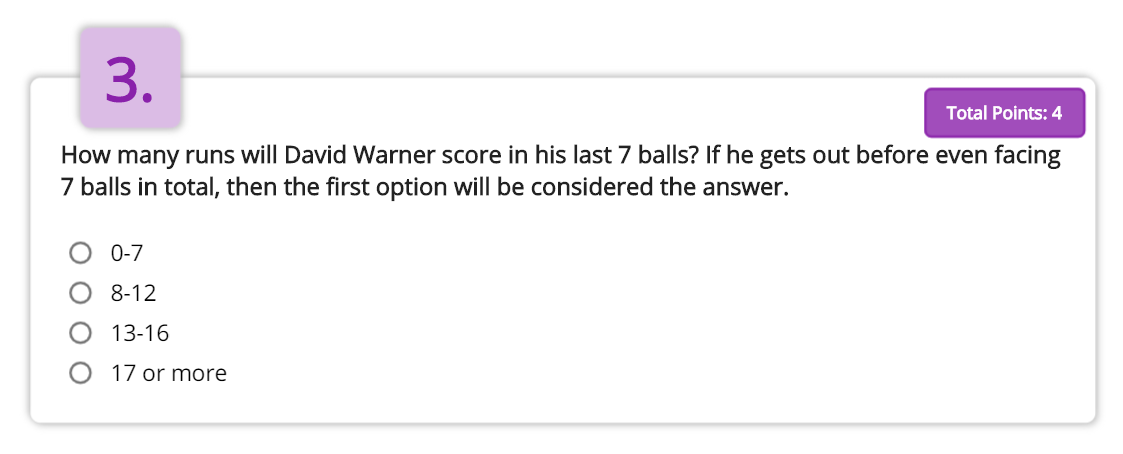

In [166]:
def warner_data(data_):
    for i in data_.match_id.unique():
        match = data_[data_.match_id ==i].reset_index()
    
        if match.ball.count() <7:
            m_id.append(i)
            balls.append(match.ball.count())
            last_balls.append(match.ball.count())
            runs_last7.append(match.batsman_runs.sum())
        else:
            m_id.append(i)
            balls.append(match.ball.count())
            runs_last7.append(match[-7:].batsman_runs.sum())
            last_balls.append(match[-7:].ball.count())
    warner_runs_data =  pd.DataFrame(list(zip(m_id, balls, last_balls, runs_last7)), 
               columns =['match_id','balls_faced', "last_balls", 'runs_scored_last7_balls'])
    return warner_runs_data


import numpy as np
import cufflinks as cf

def plot_(data, xvalue, key, label, th):
    cf.set_config_file(theme='polar',sharing='public',offline=True)
    data.iplot(kind="bar",x = xvalue,
                  subplots=False,
                  sortbars=True,
                  keys = key,
                  title=label,
                  theme=th
                  )

from bqplot import Pie
from collections import Counter
def pie_(values, labels, title_):
    pie = Pie(sizes=values, labels=labels,
          colors=["tomato", "lime", "dodgerblue", "red"], stroke="black",
          opacities = [0.8, 0.8, 0.8],
          radius=180, inner_radius=80,
          sort=True,
          display_values=True, values_format='0.0f',
          label_color="white", font_size="16px", font_weight="bolder"
          )
    fig = Figure(marks=[pie],
             legend_location = "top",
             title=title_,
             fig_margin= dict(top=60, bottom=40, left=50, right=20),
             background_style = {"fill":"silver"}
                )
    fig.layout.width="600px"
    fig.layout.height="600px"
    pie.tooltip = Tooltip(fields=['sizes'], labels=["Count"], formats=["0.5f"])
    return fig

### Overall

In [226]:
m_id=[];balls=[];runs_last7=[];last_balls=[]
dw = deliveries[deliveries.batsman == 'DA Warner']
dw_matchwise = dw[['match_id', 'ball', 'batsman_runs']]     
warner_runs_data_ = warner_data(dw_matchwise)
warner_runs_data_["index"] = warner_runs_data_.index
values =  [warner_runs_data_[warner_runs_data_.runs_scored_last7_balls <=7].shape[0],
           warner_runs_data_[(warner_runs_data_.runs_scored_last7_balls >8) & (warner_runs_data_.runs_scored_last7_balls <=12)].shape[0],
           warner_runs_data_[(warner_runs_data_.runs_scored_last7_balls >13) & (warner_runs_data_.runs_scored_last7_balls <=16)].shape[0],
           warner_runs_data_[(warner_runs_data_.runs_scored_last7_balls >17)].shape[0]]
labels= ["0-7 runs", "8-12 runs", "13-16 runs", ">17 runs"]

plot_(warner_runs_data_, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls (matchwise)", "henanigans")
fig1 = pie_(values, labels, "DA Warner's runs in last 7 balls he played")


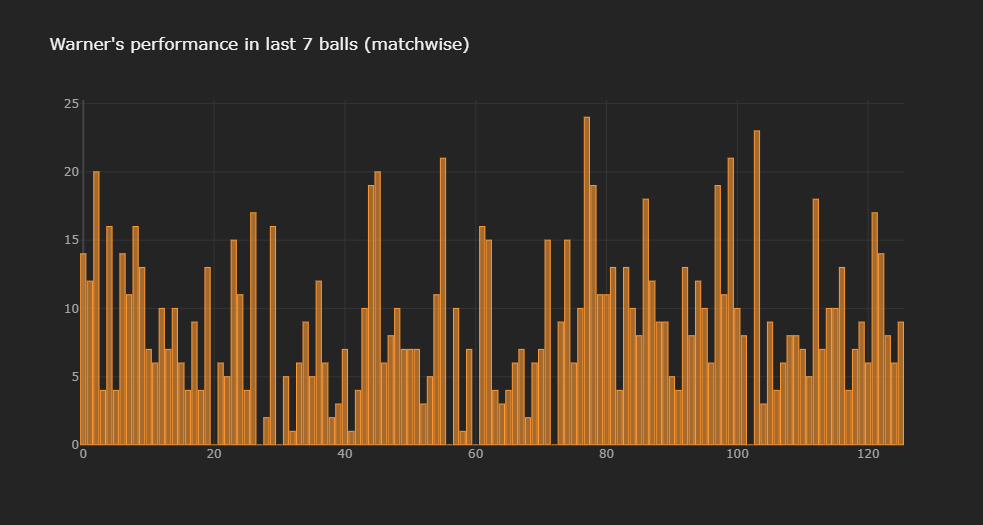

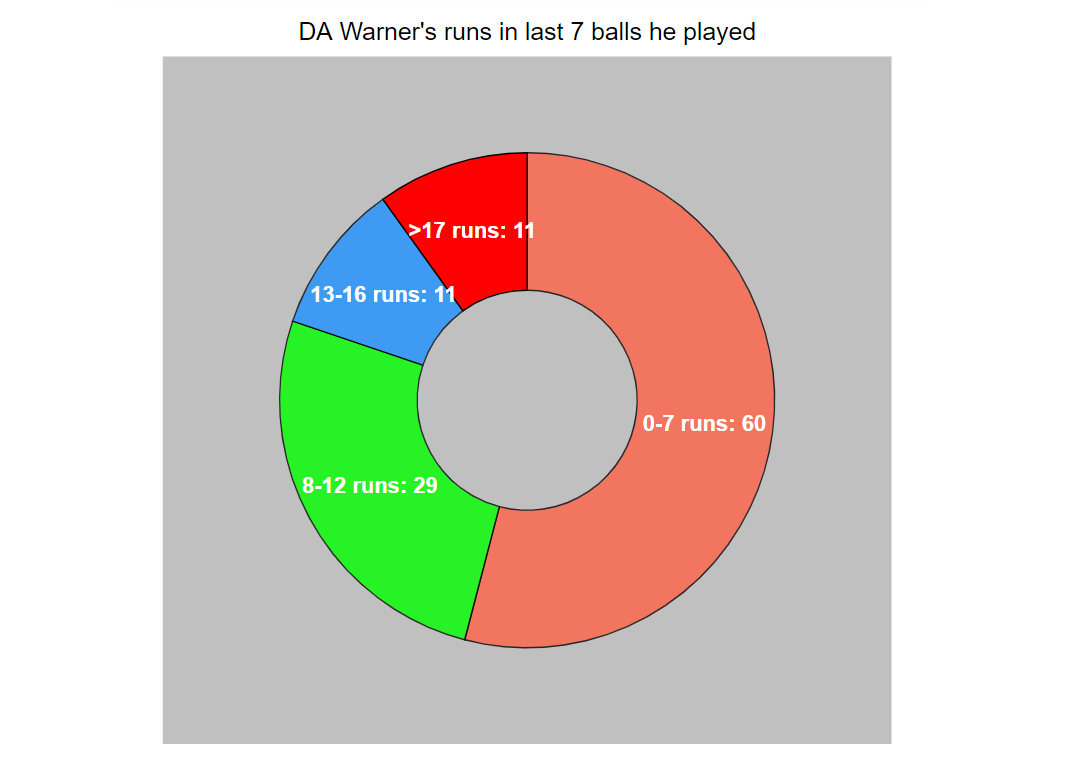

### head to head

In [227]:
m_id=[];balls=[];runs_last7=[];last_balls=[]
dw1 = deliveries[(deliveries.batsman == 'DA Warner') & (deliveries.bowler.isin(DC_bowlers))]
dw_matchwise1 = dw1[['match_id', 'ball', 'batsman_runs']]     
warner_runs_data_1 = warner_data(dw_matchwise1)
warner_runs_data_1["index"] = warner_runs_data_1.index
values1 =  [warner_runs_data_1[warner_runs_data_1.runs_scored_last7_balls <=7].shape[0],
           warner_runs_data_1[(warner_runs_data_1.runs_scored_last7_balls >8) & (warner_runs_data_1.runs_scored_last7_balls <=12)].shape[0],
           warner_runs_data_1[(warner_runs_data_1.runs_scored_last7_balls >13) & (warner_runs_data_1.runs_scored_last7_balls <=16)].shape[0],
           warner_runs_data_1[(warner_runs_data_1.runs_scored_last7_balls >17)].shape[0]]
labels1 = ["0-7 runs", "8-12 runs", "13-16 runs", ">17 runs"]

plot_(warner_runs_data_1, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against DC bowlers", "henanigans")
fig2 = pie_(values1, labels1, "DA Warner's runs in last 7 balls he played against DC bowlers")


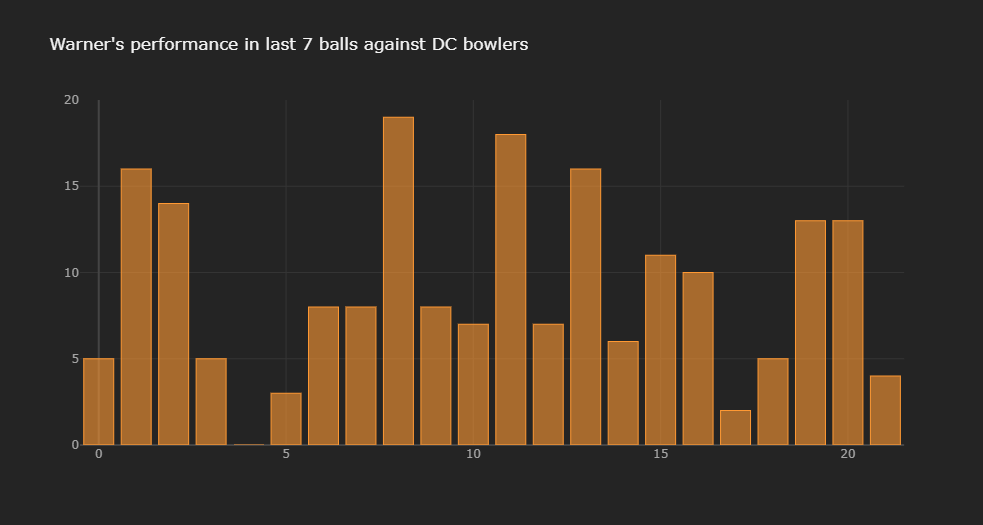

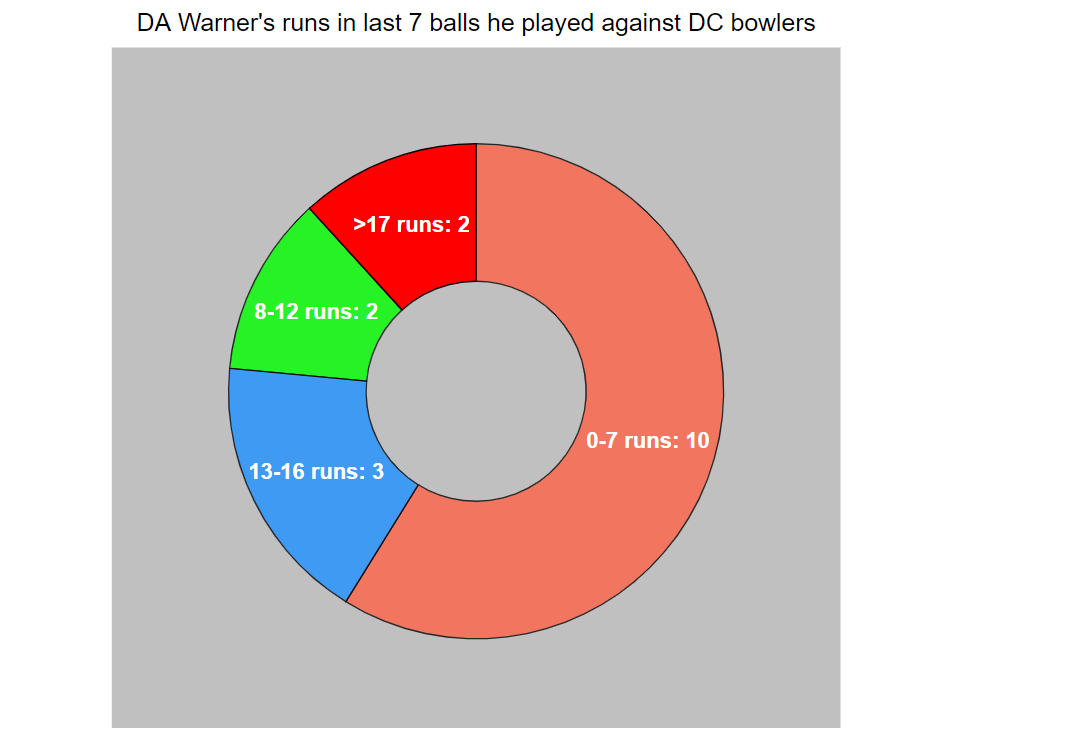

In [175]:
print("average score by Warner in last 7 balls he plays is  : ",warner_runs_data_1.runs_scored_last7_balls.mean())

average score by Warner in last 7 balls he plays is  :  9.0


In [ ]:

m_id=[];balls=[];runs_last7=[];last_balls=[]
bowler_wise = dw1[['match_id', 'bowler', 'ball', 'batsman_runs']] 
warner_runs_data_a = warner_data(bowler_wise[bowler_wise.bowler == 'K Rabada'])
warner_runs_data_a["index"] = warner_runs_data_a.index
plot_(warner_runs_data_a, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against Rabada", "henanigans")


m_id=[];balls=[];runs_last7=[];last_balls=[]
bowler_wise = dw1[['match_id', 'bowler', 'ball', 'batsman_runs']] 
warner_runs_data_b = warner_data(bowler_wise[bowler_wise.bowler == 'AR Patel'])
warner_runs_data_b["index"] = warner_runs_data_b.index
plot_(warner_runs_data_b, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against AR Patel", "henanigans")


m_id=[];balls=[];runs_last7=[];last_balls=[]
bowler_wise = dw1[['match_id', 'bowler', 'ball', 'batsman_runs']] 
warner_runs_data_c = warner_data(bowler_wise[bowler_wise.bowler == 'R Ashwin'])
warner_runs_data_c["index"] = warner_runs_data_c.index
plot_(warner_runs_data_c, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against R Ashwin", "henanigans")


m_id=[];balls=[];runs_last7=[];last_balls=[]
bowler_wise = dw1[['match_id', 'bowler', 'ball', 'batsman_runs']] 
warner_runs_data_d = warner_data(bowler_wise[bowler_wise.bowler == 'HV Patel'])
warner_runs_data_d["index"] = warner_runs_data_d.index
plot_(warner_runs_data_d, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against HV Patel", "henanigans")


m_id=[];balls=[];runs_last7=[];last_balls=[]
bowler_wise = dw1[['match_id', 'bowler', 'ball', 'batsman_runs']] 
warner_runs_data_e = warner_data(bowler_wise[bowler_wise.bowler == 'MP Stoinis'])
warner_runs_data_e["index"] = warner_runs_data_e.index
plot_(warner_runs_data_e, "index", ["runs_scored_last7_balls"], "Warner's performance in last 7 balls against MP Stoinis", "henanigans")


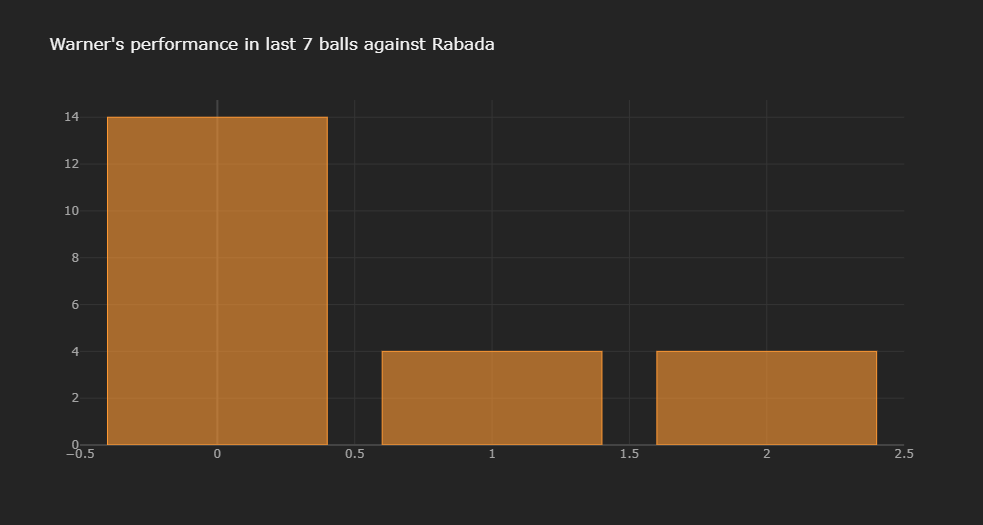

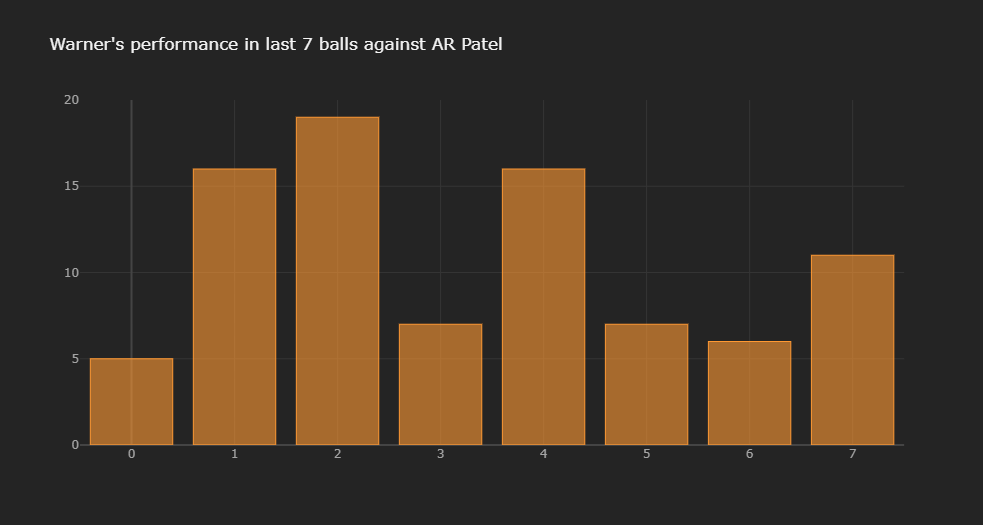

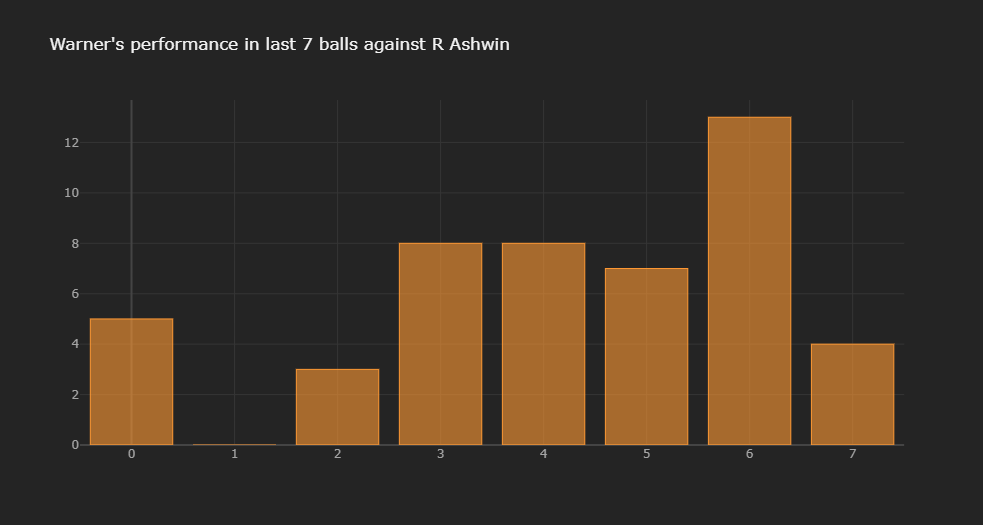

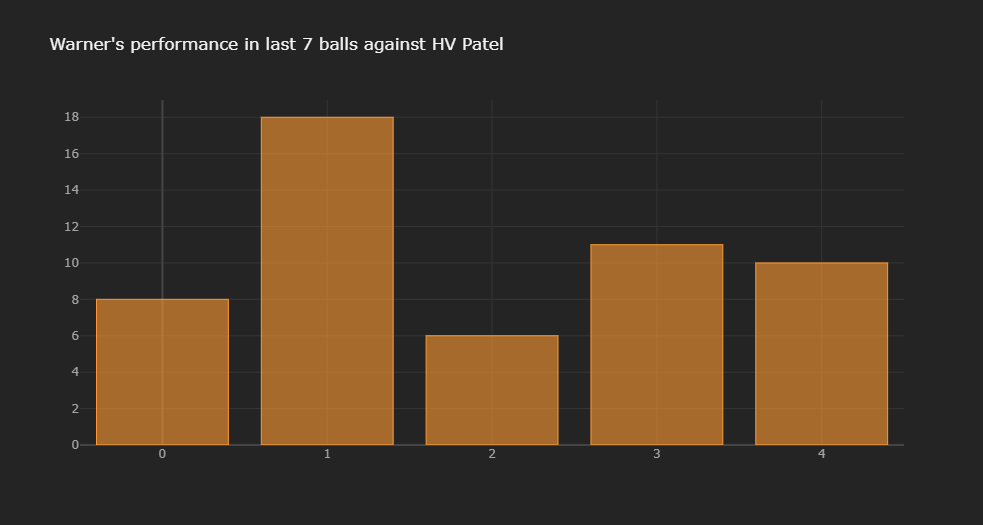

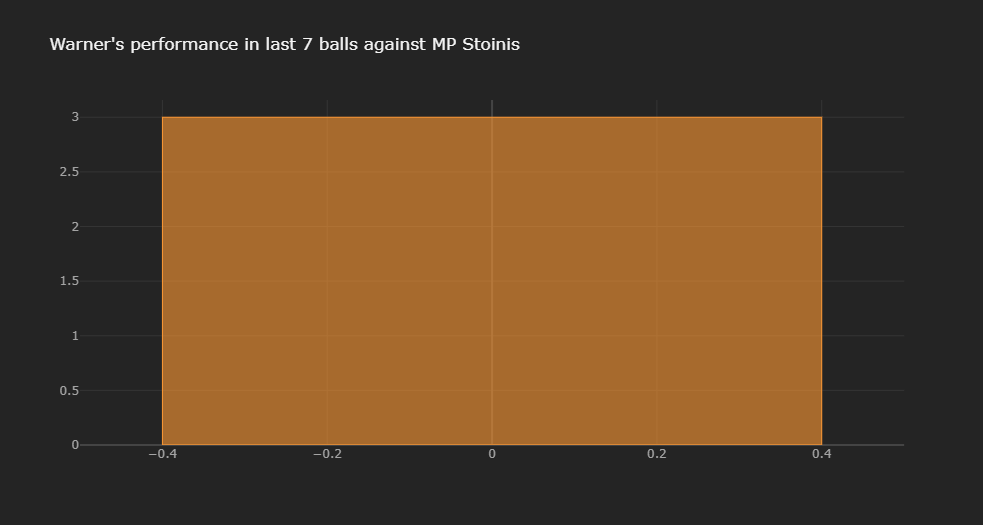

### Answer: 0-7

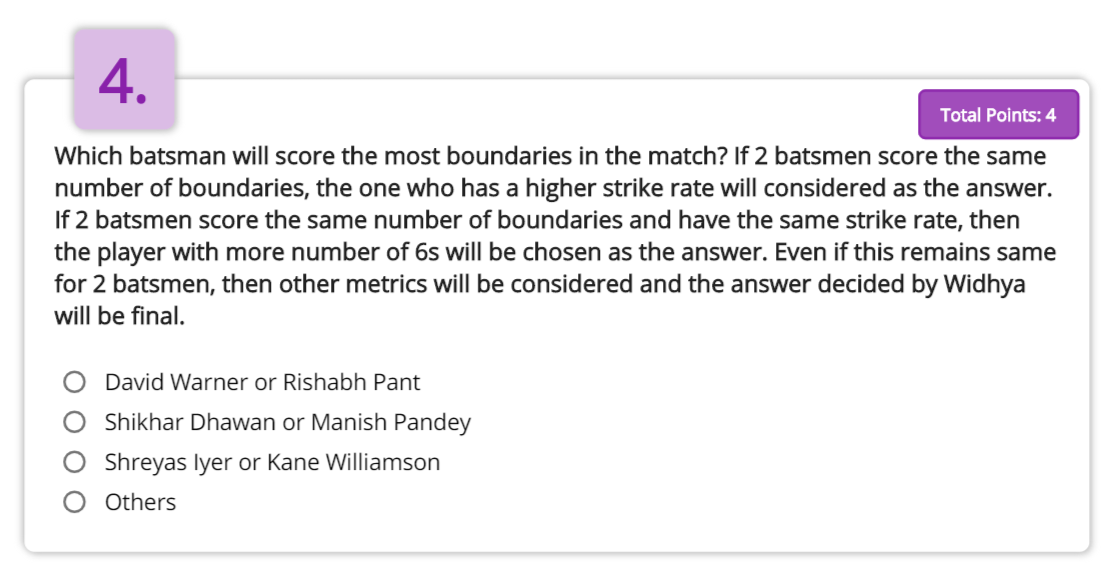
 

In [195]:
def boundaries(data_b):
    for i in data_b.batsman.unique():
        batsman.append(i)
        boundary.append(round(data_b[data_b.batsman == i].boundaries.mean(),1))
    boundaries_data =  pd.DataFrame(list(zip(batsman, boundary)), 
               columns =['batsman', 'no_of_boundaries'])
    return boundaries_data


boundaries = deliveries[deliveries.batsman.isin(DC_batsmen) | deliveries.batsman.isin(SRH_batsmen)]
batsmen_boundaries = boundaries[((boundaries.batsman_runs == 4) & (boundaries.extra_runs == 4)) | (boundaries.batsman_runs == 6)]
b_boundaries = batsmen_boundaries.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "boundaries")

batsman=[];boundary=[]
boundaries_data_ = boundaries(b_boundaries)

plot_(boundaries_data_, "batsman", ["no_of_boundaries"], "Average number of Boundaries hit by DC and SRH batsmen", "pearl")



### Head to head

In [197]:
batsmen_boundaries_faceoff = SRH_DC_faceoff[((SRH_DC_faceoff.batsman_runs == 4) & (SRH_DC_faceoff.extra_runs == 4)) | (SRH_DC_faceoff.batsman_runs == 6)]
b_boundaries_faceoff = batsmen_boundaries_faceoff.groupby(['match_id','batsman'])['batsman_runs'].count().reset_index(name = "boundaries")

batsman=[];boundary=[]
boundaries_data_faceoff = boundaries(b_boundaries_faceoff)

plot_(boundaries_data_faceoff, "batsman", ["no_of_boundaries"], "Average number of Boundaries hit by DC and SRH batsmen head to head", "pearl")


### Answer: Iyer or Williamson

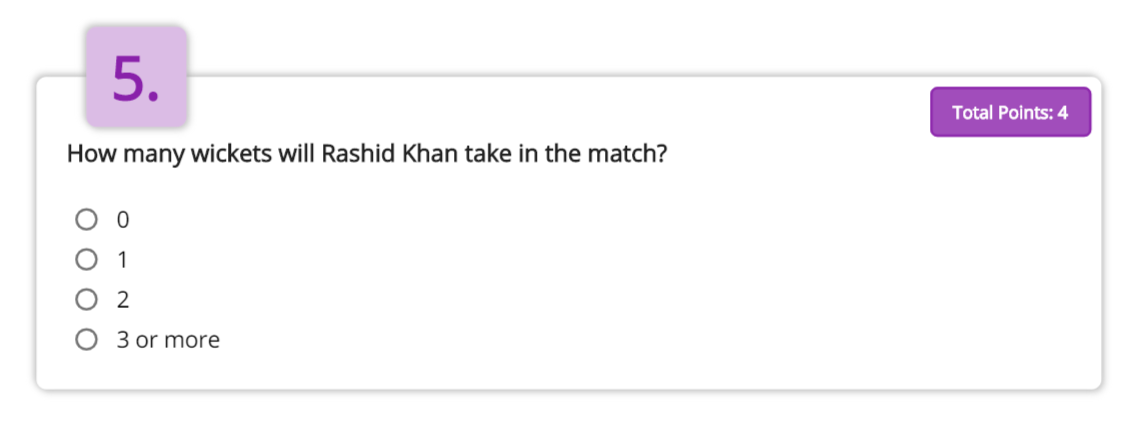

In [219]:
def wickets_taken(wickets_data_matchwise, match_data):
    for i in wickets_data_matchwise.bowler.unique():
        bowler.append(i)
        wi.append(round(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].wickets.mean(),1))
        more_wickets.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i][wickets_data_matchwise.wickets >1].match_id.unique()))
        wicket_matches.append(len(wickets_data_matchwise[wickets_data_matchwise.bowler ==i].match_id.unique()))
        
        t_matches.append(len(match_data[match_data.bowler == i].match_id.unique()))
        
    wickets_data = pd.DataFrame(list(zip(bowler, wi, t_matches, wicket_matches, more_wickets)), 
               columns =['bowler','wickets','matches', 'wicket_matches', "> 1 wicket"])
    wickets_data["wickets %"] = (wickets_data.wicket_matches/wickets_data.matches)*100
    wickets_data["more than 1 wickets %"]= (wickets_data["> 1 wicket"]/wickets_data.wicket_matches)*100

    return wickets_data 

def wickets_taken_(wickets_data_matchwise, match_data):
    for i in wickets_data_matchwise.batsman.unique():
        batsman.append(i)
        wi.append(round(wickets_data_matchwise[wickets_data_matchwise.batsman ==i].wickets.mean(),1))
        more_wickets.append(len(wickets_data_matchwise[wickets_data_matchwise.batsman ==i][wickets_data_matchwise.wickets >1].match_id.unique()))
        wicket_matches.append(len(wickets_data_matchwise[wickets_data_matchwise.batsman ==i].match_id.unique()))
        
        t_matches.append(len(match_data[match_data.batsman == i].match_id.unique()))
        
    wickets_data = pd.DataFrame(list(zip(batsman, wi, t_matches, wicket_matches)), 
               columns =['batsman','wickets','matches', 'wicket_matches'])
    wickets_data["wickets %"] = (wickets_data.wicket_matches/wickets_data.matches)*100
    
    return wickets_data

In [220]:
wickets = deliveries[deliveries.bowler == 'Rashid Khan']
wickets.player_dismissed.fillna(0, inplace = True)
wickets_SRH_DC = wickets[(wickets.player_dismissed != 0) & (wickets.dismissal_kind != 'run out')].groupby(['match_id', 'bowler'])['player_dismissed'].count().reset_index(name = "wickets")

bowler=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_SRH_DC = wickets_taken(wickets_SRH_DC, wickets)
import numpy as np
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_SRH_DC.iplot(kind="bar",x = "bowler",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "> 1 wicket", "wickets %", "more than 1 wickets %"],
                  title="Wickets stats for Rashid Khan overall",
                  theme="henanigans"
                  )


wickets_data_SRH_DC

,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,Rashid Khan,1.5,46,36,13,78.26087,36.111111


In [223]:
wickets_faceoff = deliveries[(deliveries.bowler == 'Rashid Khan') & (deliveries.batsman.isin(DC_batsmen))]
wickets_faceoff.player_dismissed.fillna(0, inplace = True)
wickets_SRH_DC_faceoff = wickets_faceoff[(wickets_faceoff.player_dismissed != 0) & (wickets_faceoff.dismissal_kind != 'run out')].groupby(['match_id', 'batsman'])['player_dismissed'].count().reset_index(name = "wickets")
wickets_SRH_DC_faceoff2 = wickets_faceoff[(wickets_faceoff.player_dismissed != 0) & (wickets_faceoff.dismissal_kind != 'run out')].groupby(['match_id', 'bowler'])['player_dismissed'].count().reset_index(name = "wickets")

batsman=[];wi=[];wicket_matches=[];t_matches=[];more_wickets=[]
wickets_data_SRH_DC_faceoff = wickets_taken_(wickets_SRH_DC_faceoff, wickets_faceoff)
wickets_data_SRH_DC_faceoff_2 = wickets_taken(wickets_SRH_DC_faceoff2, wickets_faceoff)

import numpy as np
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)
wickets_data_SRH_DC_faceoff.iplot(kind="bar",x = "batsman",
                  subplots=False,
                  sortbars=True,
                  keys = ["wickets","matches", "wicket_matches", "wickets %"],
                  title="Wickets stats for Rashid Khan against DC batsmen",
                  theme="henanigans"
                  )


wickets_data_SRH_DC_faceoff

,batsman,wickets,matches,wicket_matches,wickets %
0,P Shaw,1.0,2,1,50.000000
1,RR Pant,1.0,5,1,20.000000
2,SS Iyer,1.0,6,1,16.666667
3,AR Patel,1.0,4,1,25.000000


In [225]:
# Head to head against DC batsmen
wickets_data_SRH_DC_faceoff_2

,bowler,wickets,matches,wicket_matches,> 1 wicket,wickets %,more than 1 wickets %
0,Rashid Khan,1.0,2,1,0,50.0,0.0
1,Rashid Khan,1.0,5,1,0,20.0,0.0


## 1 wicket